In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi64')

In [44]:
%%px
# Import the libraries

import os
import sys
import math
import pyJHTDB
import numpy as np
import pyfftw as ft 
from mpi4py import MPI
from pyJHTDB import libJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse

from mpiFFT4py.slab import R2C

In [45]:
%%px

Nx = isotropic1024coarse['nx']; Ny = isotropic1024coarse['ny']; Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']; Ly = isotropic1024coarse['ly']; Lz = isotropic1024coarse['lz']

######################################

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

[stdout:49] 
n_proc = 64
rank = 0


In [46]:
%%px

######################################
#      Computational Domain          #
######################################

nx=Nx//nproc; ny=Ny; nz=Nz
time = 0.0

########## FFT alocation #############

N = np.array([Nx,Ny,Nz],dtype=int)
L = np.array([Lx,Ly,Lz],dtype=float)

FFT = R2C(N, L, MPI.COMM_WORLD, "double", communication='Alltoallw')

######### Vector alocation ###########

In [47]:
%%px

if rank==0:
    print(FFT.real_shape())

[stdout:49] (16, 1024, 1024)


In [48]:
%%px

######### Vector alocation ###########

dx = isotropic1024coarse['dx']

comm.Barrier(); t1=MPI.Wtime()

X = np.zeros(FFT.real_shape(), dtype=FFT.float)
Y = np.zeros(FFT.real_shape(), dtype=FFT.float)
Z = np.zeros(FFT.real_shape(), dtype=FFT.float)

r2 = np.zeros(FFT.real_shape(), dtype=FFT.float)

chi = np.zeros(FFT.real_shape(), dtype=FFT.float)
cchi = np.zeros(FFT.complex_shape(), dtype=FFT.complex)
corr = np.zeros(FFT.real_shape(), dtype=FFT.float)
iCorr = np.zeros(FFT.real_shape(), dtype=FFT.float)

r2Sum = np.zeros(FFT.real_shape(), dtype=FFT.float)
r2F = np.zeros(FFT.real_shape(), dtype=FFT.float)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Alocating vectors: {0:.2f} seconds\n'.format(t2-t1))

[stdout:49] Alocating vectors: 0.06 seconds


In [49]:
%%px

####### Spatial Information #########

comm.Barrier(); t1=MPI.Wtime()
for i in range(nx):
    if (i+nx*rank)<Nx//2:
        X[i,:,:] = (i+nx*rank)*isotropic1024coarse['dx']
    else:
        X[i,:,:] = isotropic1024coarse['lx']-(i+nx*rank)*isotropic1024coarse['dx']
    
for j in range(ny):
    if j<Ny//2:
        Y[:,j,:] = j*isotropic1024coarse['dy']
    else:
        Y[:,j,:] = isotropic1024coarse['ly']-j*isotropic1024coarse['dy']
    
for k in range(nz):
    if k<Nz//2:
        Z[:,:,k] = k*isotropic1024coarse['dz']
    else:
        Z[:,:,k] = isotropic1024coarse['lz']-k*isotropic1024coarse['dz']
    
r2[:,:,:] = X[:,:,:]**2+Y[:,:,:]**2+Z[:,:,:]**2

r2rt = np.sqrt(r2)
del r2

######## Domain boundaries ##########

minrt = r2rt.min()
maxrt = r2rt.max()

minr2Gl=np.zeros(nproc,dtype=FFT.float)
maxr2Gl=np.zeros(nproc,dtype=FFT.float)

comm.Allgather([minrt,MPI.DOUBLE],[minr2Gl,MPI.DOUBLE])
comm.Allgather([maxrt,MPI.DOUBLE],[maxr2Gl,MPI.DOUBLE])

minrt = minr2Gl.min()
maxrt = maxr2Gl.max()

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Preparing the real domain for radial integration: {0:.2f} seconds\n'.format(t2-t1))

ner = int((maxrt-minrt)/isotropic1024coarse['dx'])

rbins = np.linspace(minrt,maxrt,ner+1)

[stdout:49] Preparing the real domain for radial integration: 5.49 seconds


In [50]:
%%px

###################################
######## Reading Data #############
###################################

folder = '/home/jhelsas/scratch/slab64'

##########

filename = 'ref-Q-'+str(rank)+'.npz'
file = folder + "/" + filename

comm.Barrier(); t1=MPI.Wtime()
content = np.load(file)
    
Q = np.zeros(FFT.real_shape(), dtype=FFT.float)
Q[:,:,:] = content['Q'].astype(FFT.float)
    
comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    print("Finished loading")
    sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

[stdout:49] 
Finished loading
Load from disk: 1.02 seconds


In [51]:
%%px

filename = 'ref-R-'+str(rank)+'.npz'
file = folder + "/" + filename

comm.Barrier(); t1=MPI.Wtime()
content = np.load(file)
    
R = np.zeros(FFT.real_shape(), dtype=FFT.float)
R[:,:,:] = content['R'].astype(FFT.float)
    
comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    print("Finished loading")
    sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

#########

[stdout:49] 
Finished loading
Load from disk: 1.01 seconds


In [52]:
%%px

filename = 'ref-strainrate-'+str(rank)+'.npz'
file = folder + "/" + filename

comm.Barrier(); t1=MPI.Wtime()
content = np.load(file)
    
S2 = np.zeros(FFT.real_shape(), dtype=FFT.float)
    
S2[:,:,:] = content['S2'].astype(FFT.float)
    
comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    print("Finished loading")
    sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

[stdout:49] 
Finished loading
Load from disk: 1.09 seconds


In [53]:
%%px

#######################################
##### Finding field parameters ########
#######################################

avgE = np.average(S2)
avgEGl=np.zeros(1,dtype=FFT.float)
comm.Allreduce([avgE,MPI.DOUBLE],[avgEGl,MPI.DOUBLE],op=MPI.SUM)
avgE = avgEGl[0]/nproc
if rank == 0:
    print(avgE)
    
avg = avgE

#################################################

minS2 = S2.min(); maxS2 = S2.max()

minS2Gl=np.zeros(nproc,dtype=FFT.float)
maxS2Gl=np.zeros(nproc,dtype=FFT.float)

comm.Allgather([minS2,MPI.DOUBLE],[minS2Gl,MPI.DOUBLE])
comm.Allgather([maxS2,MPI.DOUBLE],[maxS2Gl,MPI.DOUBLE])

minE = minS2Gl.min(); maxE = maxS2Gl.max()
if rank==0:
    print(minE/avg,maxE/avg)

[stdout:49] 
249.217673008
(3.9848990133269396e-05, 225.01040811291978)


In [54]:
%%px

comm.Barrier()

################################################
######### Finding min and max Q/R ##############
################################################

Q = Q/avg
R = R/(avg**1.5)

In [70]:
%%px

qmin = np.min(Q)
qmax = np.max(Q)
rmin = np.min(R)
rmax = np.max(R)

print(str(rank)+": ",qmin,qmax,rmin,rmax)

[stdout:0] ('18: ', -37.448382835283368, 168.59267214222797, -192.52748544785368, 254.80547868124214)
[stdout:1] ('20: ', -32.190050942268826, 95.635554352228397, -158.62628070505301, 98.631218063151138)
[stdout:2] ('5: ', -42.01514630083264, 142.02219681708783, -252.19177192714849, 174.57901041032321)
[stdout:3] ('46: ', -41.721904437984776, 115.81007727254719, -221.15981448938263, 145.98553827465039)
[stdout:4] ('15: ', -34.91600512052338, 110.1337753130985, -159.2758391774783, 112.36809538011448)
[stdout:5] ('19: ', -24.831429800498707, 147.91587432406939, -162.43892793288975, 107.87339507603855)
[stdout:6] ('35: ', -40.616237434170131, 129.91520876039735, -187.162754239658, 125.6662995170648)
[stdout:7] ('16: ', -34.79891213802027, 121.90505658988782, -137.24526031475537, 68.258398294143873)
[stdout:8] ('4: ', -54.610917817749666, 126.63077450410982, -209.11406247269073, 167.55688760569316)
[stdout:9] ('53: ', -35.592128732028002, 118.80018423809872, -139.67836029751678, 89.1656853

In [71]:
%%px

minQ = np.min(Q); maxQ = np.max(Q)

minQGl=np.zeros(nproc,dtype=FFT.float)
maxQGl=np.zeros(nproc,dtype=FFT.float)

comm.Allgather([minQ,MPI.DOUBLE],[minQGl,MPI.DOUBLE])
comm.Allgather([maxQ,MPI.DOUBLE],[maxQGl,MPI.DOUBLE])

if rank==0:
    print(minQ,maxQ)

minQ = minQGl.min(); maxQ = maxQGl.max()

##########################################

minR = np.min(R); maxR = np.max(R)

minRGl=np.zeros(nproc,dtype=FFT.float)
maxRGl=np.zeros(nproc,dtype=FFT.float)

comm.Allgather([minR,MPI.DOUBLE],[minRGl,MPI.DOUBLE])
comm.Allgather([maxR,MPI.DOUBLE],[maxRGl,MPI.DOUBLE])

if rank==0:
    print(minR,maxR)
    
minR = minRGl.min(); maxR = maxRGl.max()

if rank==0:
    for k in range(nproc):
        print(round(minQGl[k],5),round(maxQGl[k],5),round(minRGl[k],5),round(maxRGl[k],5))

[stdout:49] 
(-50.068221854326559, 152.6352207374029)
(-264.43272985518973, 216.06563600548628)
(-50.06822, 152.63522, -264.43273, 216.06564)
(-48.29527, 128.52846, -183.22197, 122.66139)
(-54.16208, 131.54312, -177.5528, 151.43402)
(-62.04073, 216.44642, -281.41769, 248.55689)
(-54.61092, 126.63077, -209.11406, 167.55689)
(-42.01515, 142.0222, -252.19177, 174.57901)
(-46.81791, 119.07951, -155.94531, 136.82681)
(-61.41752, 117.16424, -224.67354, 148.17244)
(-65.86876, 148.23972, -363.22765, 202.6231)
(-40.94572, 106.84498, -182.09952, 97.05543)
(-25.94289, 116.71604, -141.30836, 83.65632)
(-26.14684, 112.31097, -88.49053, 90.61654)
(-36.37568, 145.56916, -136.14351, 119.33793)
(-31.53944, 133.09684, -140.5233, 74.17868)
(-62.58017, 137.11928, -258.88186, 187.81968)
(-34.91601, 110.13378, -159.27584, 112.3681)
(-34.79891, 121.90506, -137.24526, 68.2584)
(-30.09933, 85.18046, -98.58675, 75.08447)
(-37.44838, 168.59267, -192.52749, 254.80548)
(-24.83143, 147.91587, -162.43893, 107.8734)


In [72]:
%%px

if rank==0:
    print(minQ,maxQ,minR,maxR)

[stdout:49] (-92.158000139121256, 305.63790387783143, -475.85866702503751, 451.61272029388857)


In [75]:
%%px

def FindJointPDF(x,y,lowerLim_x,upperLim_x,lowerLim_y,upperLim_y,bins_x,bins_y):
    x=x.flatten()
    y=y.flatten()
    totL=len(x)
    xedges=np.linspace(lowerLim_x,upperLim_x,bins_x+1,endpoint=True); dx=xedges[1]-xedges[0]
    yedges=np.linspace(lowerLim_y,upperLim_y,bins_y+1,endpoint=True); dy=yedges[1]-yedges[0]
    jPDF,xedges,yedges=np.histogram2d(x,y,bins=(xedges,yedges))
    jPDF=jPDF/(dx*dy*totL)
    gridX,gridY=np.meshgrid(xedges[0:-1]+0.5*dx,yedges[0:-1]+0.5*dy)
    return jPDF.T,gridX,gridY

In [76]:
%%px

q=Q.flatten()
r=R.flatten()

In [77]:
%%px

Ngrid=960;rmin=-60.0;rmax=60.0;qmin=-60.0;qmax=60.0 # Constants for jPDF
jPDF,gridX,gridY=FindJointPDF(r,q,rmin,rmax,qmin,qmax,Ngrid,Ngrid)

In [78]:
%%px

gPDF = np.zeros(jPDF.shape,dtype='float32')
jPDF = jPDF.astype(dtype='float32')

if rank==0:
    print(jPDF.shape,jPDF.dtype)
    print(gPDF.shape,gPDF.dtype)

[stdout:49] 
((960, 960), dtype('float32'))
((960, 960), dtype('float32'))


In [81]:
%%px 

comm.Allreduce([jPDF,MPI.REAL],[gPDF,MPI.REAL],op=MPI.SUM)

In [83]:
%%px

jPDF=gPDF/nproc

[stderr:49] /home/jhelsas/anaconda2/lib/python2.7/site-packages/ipyparallel/engine/__main__.py:29: RuntimeWarning: divide by zero encountered in log10


[output:49]

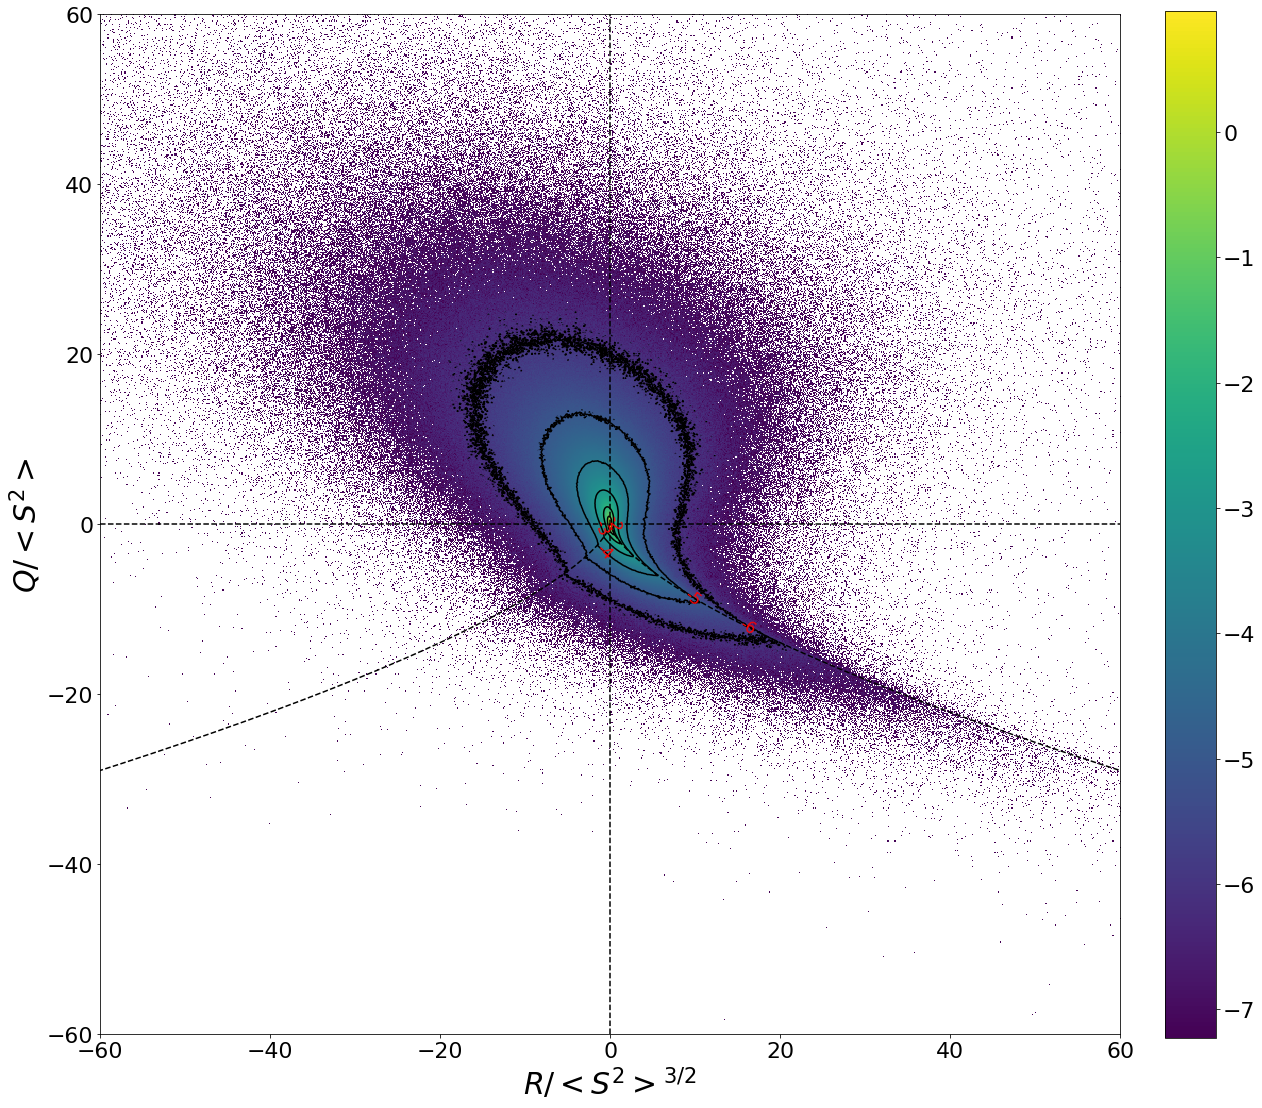

In [88]:
%%px

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

if rank==0:
    fmt={}
    fig = plt.figure(figsize=(20,20))
    SIZE=20
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+8)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)  # legend fontsize
    plt.axis([rmin,rmax,qmin,qmax])
    plt.xlabel('$R/<S^2>^{3/2}$',fontsize=30)
    plt.ylabel('$Q/<S^2>$',fontsize=30)
    Qc=np.linspace(qmin,0,50)
    Rc1=-(2./27.)*((-3.*Qc)**1.5)
    Rc2=(2./27.)*((-3.*Qc)**1.5)
    plt.plot(Rc1,Qc,'--k')
    plt.plot(Rc2,Qc,'--k')
    plt.plot([0,0],[qmin,qmax],'--k')
    plt.plot([rmin,rmax],[0,0],'--k')
    plt.axis([rmin,rmax,qmin,qmax])

    logjPDF = np.log10(jPDF)
    cax = plt.imshow(logjPDF.T,interpolation='none',extent=(rmin,rmax,qmin,qmax),origin='lower', aspect='equal')
    cbar = fig.colorbar(cax,fraction=0.046, pad=0.04)

    N = 6
    levels=np.logspace(-N,-1,num=N,base=10.0)#np.logspace[1e-5,1e-4,1e-3,1e-2,1e-1]
    CS=plt.contour(gridX,gridY,jPDF.T,levels,colors='k')#[1::2] #extent=(-15,15,-15,15)
    strs=['-6','-5','-4','-3','-2','-1']
    for l,s in zip(CS.levels,strs):
        fmt[l]=s
    plt.clabel(CS,levels,inline=False,fmt=fmt,fontsize=16,colors='r')

[stderr:49] 
/home/jhelsas/anaconda2/lib/python2.7/site-packages/ipyparallel/engine/__main__.py:29: RuntimeWarning: divide by zero encountered in log10
/home/jhelsas/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


[output:49]

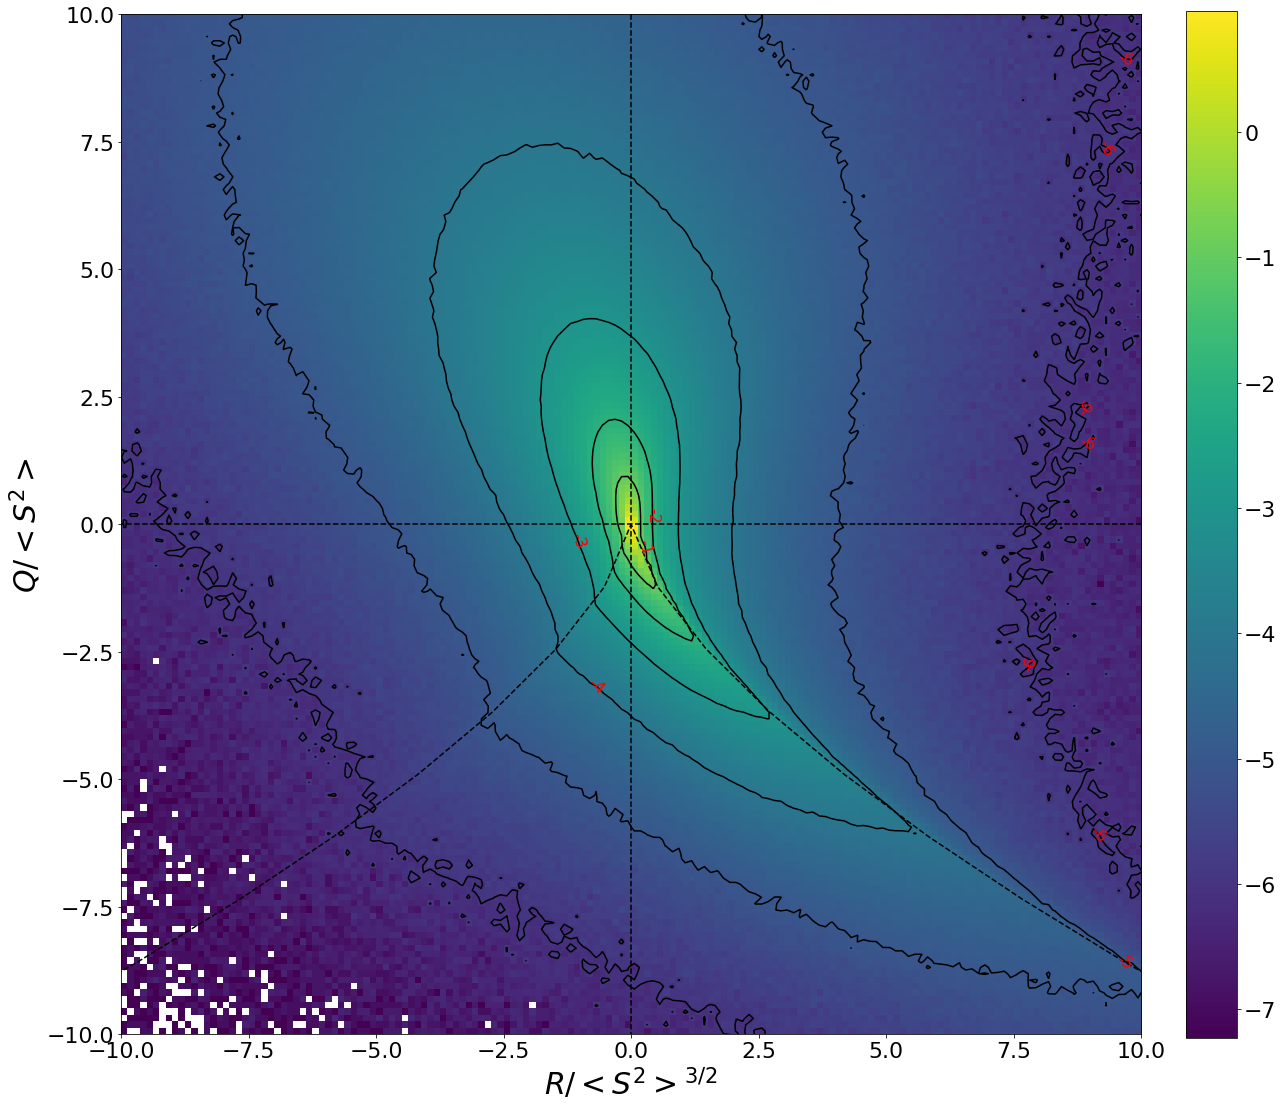

In [89]:
%%px

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

if rank==0:
    fmt={}
    fig = plt.figure(figsize=(20,20))
    SIZE=20
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+8)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE+2)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)  # legend fontsize
    plt.xlabel('$R/<S^2>^{3/2}$',fontsize=30)
    plt.ylabel('$Q/<S^2>$',fontsize=30)
    Qc=np.linspace(qmin,0,50)
    Rc1=-(2./27.)*((-3.*Qc)**1.5)
    Rc2=(2./27.)*((-3.*Qc)**1.5)
    plt.plot(Rc1,Qc,'--k')
    plt.plot(Rc2,Qc,'--k')
    plt.plot([0,0],[qmin,qmax],'--k')
    plt.plot([rmin,rmax],[0,0],'--k')
    plt.axis([rmin,rmax,qmin,qmax])
    plt.axis([-10,10,-10,10])

    logjPDF = np.log10(jPDF)
    cax = plt.imshow(logjPDF.T,interpolation='none',extent=(rmin,rmax,qmin,qmax),origin='lower', aspect='equal')
    cbar = fig.colorbar(cax,fraction=0.046, pad=0.04)

    N = 6
    levels=np.logspace(-N,-1,num=N,base=10.0)#np.logspace[1e-5,1e-4,1e-3,1e-2,1e-1]
    CS=plt.contour(gridX,gridY,jPDF.T,levels,colors='k')#[1::2] #extent=(-15,15,-15,15)
    strs=['-6','-5','-4','-3','-2','-1']
    for l,s in zip(CS.levels,strs):
        fmt[l]=s
    plt.clabel(CS,levels,inline=False,fmt=fmt,fontsize=16,colors='r')

In [90]:
%%px

comm.Barrier(); t1=MPI.Wtime()

minJ = -0.5; maxJ =  0.5; E_bins = 5
tl = np.linspace(minJ,maxJ,num=E_bins,endpoint=True) 

if rank == 0:
    print("Q and R min/max : ",minQ,maxQ,minR,maxR)

##################################

if rank==0:
    print("Computation Boundaries : ",minJ,maxJ)
    print(tl)
    
lcorr = []; llogr = []; volFr = []

threshold = ((10.0)**3)/((1024.0)**3)

######################################

[stdout:49] 
('Q and R min/max : ', -92.158000139121256, 305.63790387783143, -475.85866702503751, 451.61272029388857)
('Computation Boundaries : ', -0.5, 0.5)
[-0.5  -0.25  0.    0.25  0.5 ]


In [91]:
%%px

comm.Barrier(); t1=MPI.Wtime()

for i in range(E_bins-1):
    comm.Barrier(); istart=MPI.Wtime()
    if(rank==0):
        print("Line - "+str(i))
    
    for j in range(E_bins-1):
        comm.Barrier(); jstart=MPI.Wtime()
                
        tQm = tl[i]; tQM = tl[i+1]; tRm = tl[j]; tRM = tl[j+1]
        Index = (Q>tQm)&(Q<tQM)&(R>tRm)&(R<tRM)
        
        chi[:,:,:] = 0
        chi[Index] = 1
        
        vf = np.average(chi)
        vgl = np.zeros(1,dtype=FFT.float)
        comm.Allreduce([vf,MPI.DOUBLE],[vgl,MPI.DOUBLE],op=MPI.SUM)
        vf = vgl/nproc
                    
        if vf>threshold:
            cchi = FFT.fftn(chi,cchi)
            tmp = cchi*(cchi.conj())
            corr = FFT.ifftn(tmp,corr)
            corr[:,:,:] = corr[:,:,:]/(Nx*Ny*Nz)
                        
            corrLoc,redges = np.histogram(r2rt,bins = rbins,weights=corr)
            r2Loc,r2edges = np.histogram(r2rt,bins = rbins)
            
            corrSum = np.zeros(corrLoc.shape,dtype=corrLoc.dtype)
            comm.Allreduce([corrLoc,MPI.DOUBLE],[corrSum,MPI.DOUBLE],op=MPI.SUM)
            r2Sum = np.zeros(r2Loc.shape,dtype=r2Loc.dtype)
            comm.Allreduce([r2Loc,MPI.DOUBLE],[r2Sum,MPI.DOUBLE],op=MPI.SUM)
        else:
            corrSum = np.zeros(rbins.shape)
            r2Loc = np.ones(rbins.shape)
                        
        if rank==0:
            volFr.append(vf)
            llogr.append(r2Sum)
            lcorr.append(corrSum)
        
        comm.Barrier(); jend=MPI.Wtime()
        if rank==0:
            print("time for iteration: "+str(jend-jstart))
        
    comm.Barrier(); iend=MPI.Wtime()    
    if rank==0:
        print("time to process line: "+str(iend-istart))

comm.Barrier(); t2=MPI.Wtime()

if rank==0:
    print("Total computing time: "+str(t2-t1))

[stdout:49] 
Line - 0
time for iteration: 90.0697100163
time for iteration: 30.5338759422
time for iteration: 24.9453728199
time for iteration: 36.2597720623
time to process line: 181.85750699
Line - 1
time for iteration: 30.5170300007
time for iteration: 37.3425090313
time for iteration: 24.7815110683
time for iteration: 39.0188369751
time to process line: 131.720674038
Line - 2
time for iteration: 26.5991179943
time for iteration: 34.8101100922
time for iteration: 23.3099849224
time for iteration: 35.1332559586
time to process line: 119.924026012
Line - 3
time for iteration: 23.054598093
time for iteration: 38.9787199497
time for iteration: 22.8116538525
time for iteration: 31.9202342033
time to process line: 116.805756807
Total computing time: 550.37033391


[stdout:49] 
t = (-0.3750000,-0.3750000)*sigma_2: Linear fit [alpha A] = 2.663
t = (-0.3750000,-0.1250000)*sigma_2: Linear fit [alpha A] = 2.883
t = (-0.3750000,0.1250000)*sigma_2: Linear fit [alpha A] = 2.973
t = (-0.3750000,0.3750000)*sigma_2: Linear fit [alpha A] = 2.724
t = (-0.1250000,-0.3750000)*sigma_2: Linear fit [alpha A] = 2.724
t = (-0.1250000,-0.1250000)*sigma_2: Linear fit [alpha A] = 2.986
t = (-0.1250000,0.1250000)*sigma_2: Linear fit [alpha A] = 2.951
t = (-0.1250000,0.3750000)*sigma_2: Linear fit [alpha A] = 2.730
t = (0.1250000,-0.3750000)*sigma_2: Linear fit [alpha A] = 2.786
t = (0.1250000,-0.1250000)*sigma_2: Linear fit [alpha A] = 2.957
t = (0.1250000,0.1250000)*sigma_2: Linear fit [alpha A] = 2.965
t = (0.1250000,0.3750000)*sigma_2: Linear fit [alpha A] = 2.753
t = (0.3750000,-0.3750000)*sigma_2: Linear fit [alpha A] = 2.844
t = (0.3750000,-0.1250000)*sigma_2: Linear fit [alpha A] = 2.985
t = (0.3750000,0.1250000)*sigma_2: Linear fit [alpha A] = 2.977
t = (0.3750

[output:49]

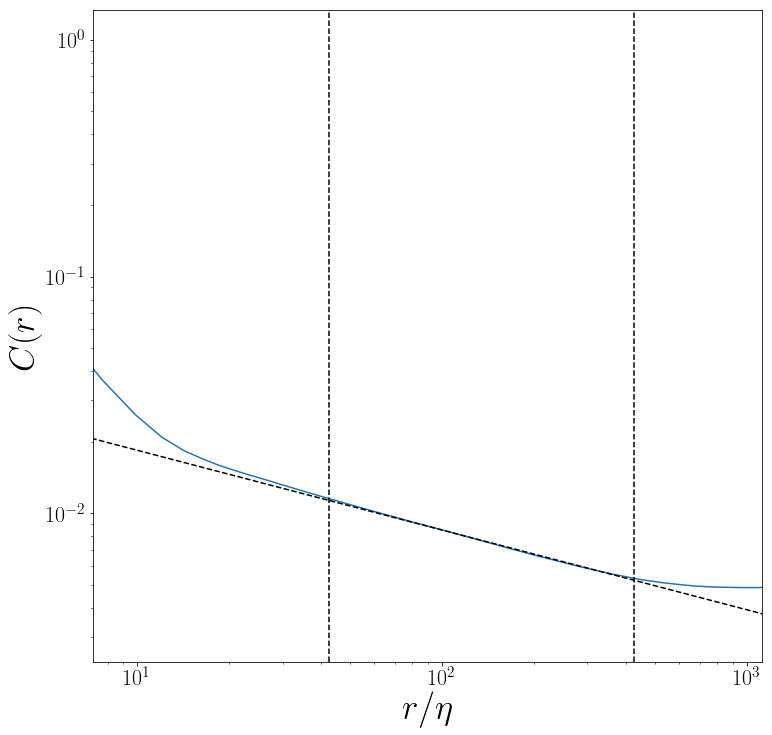

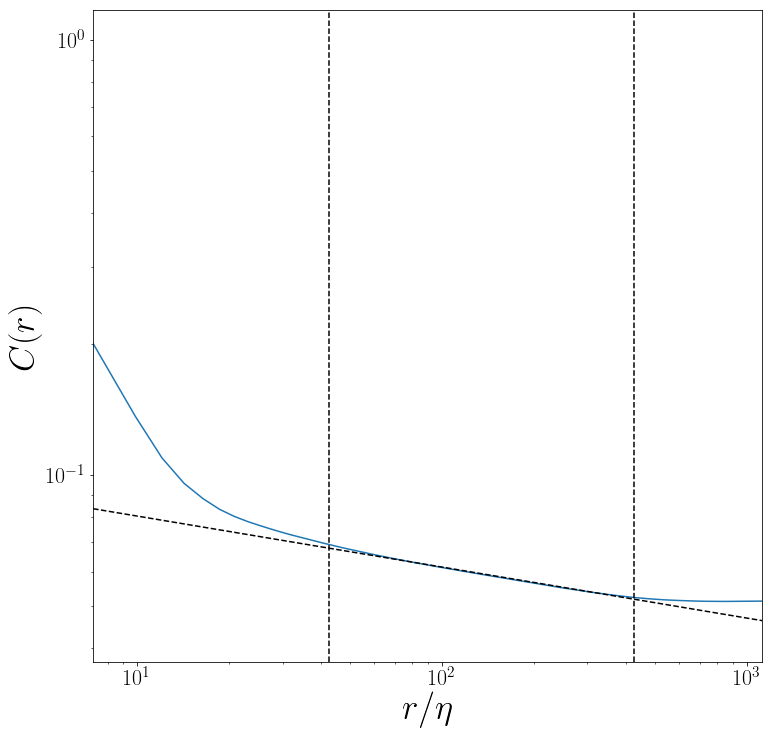

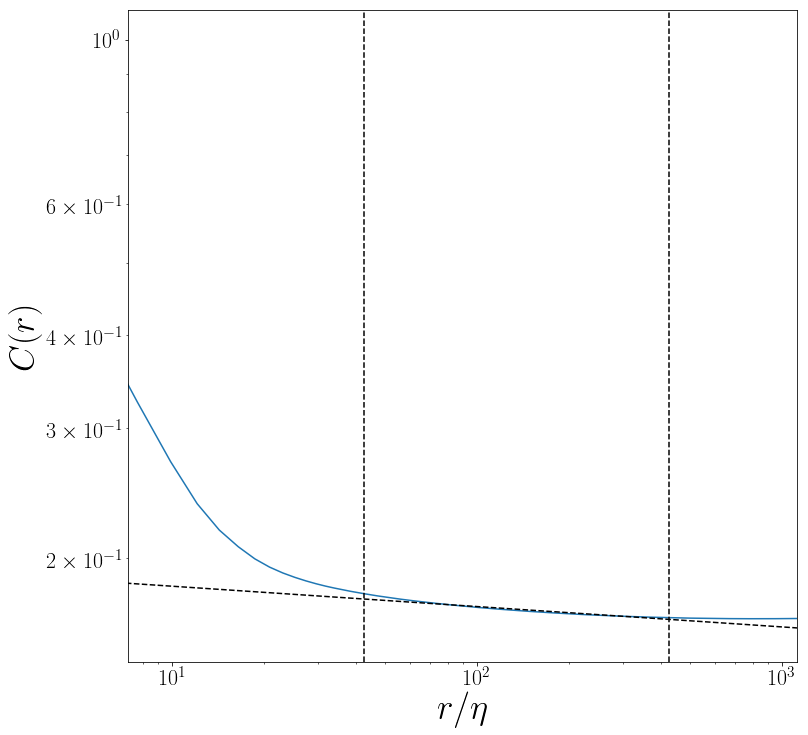

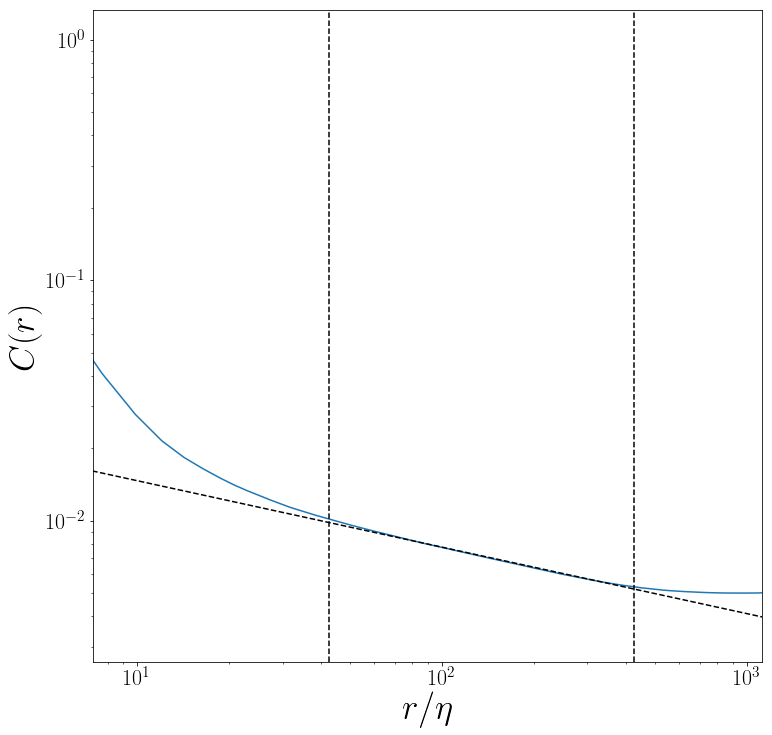

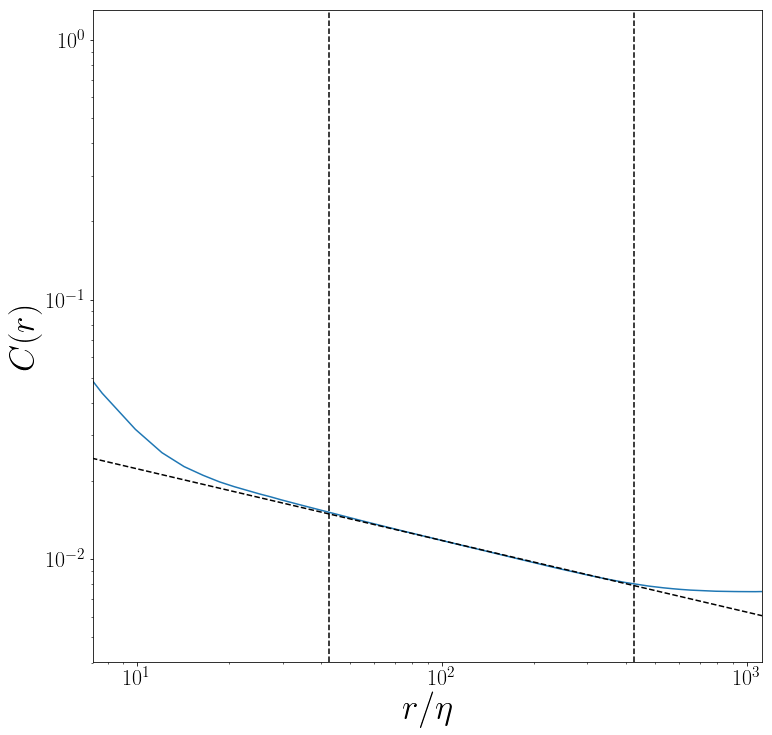

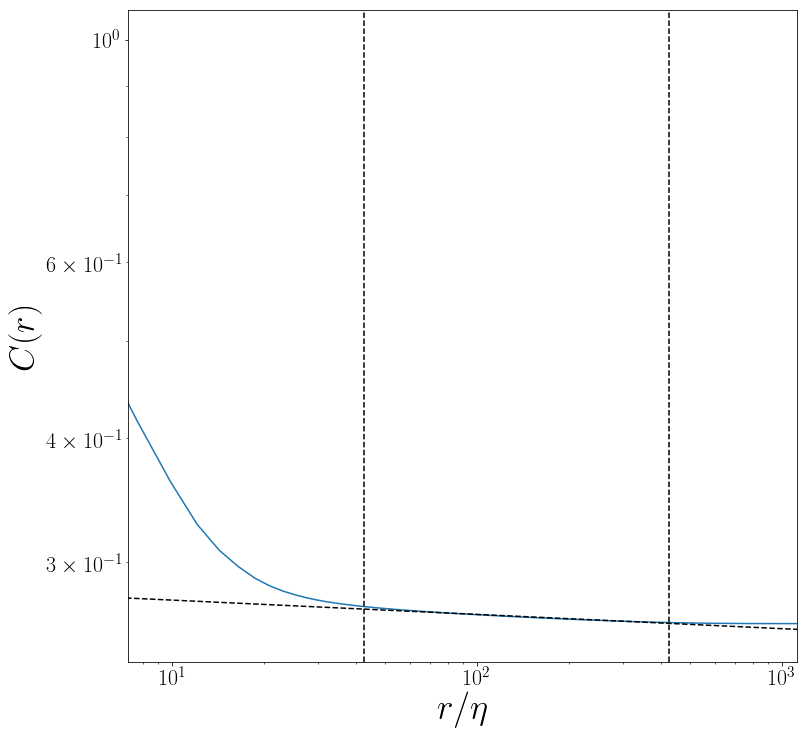

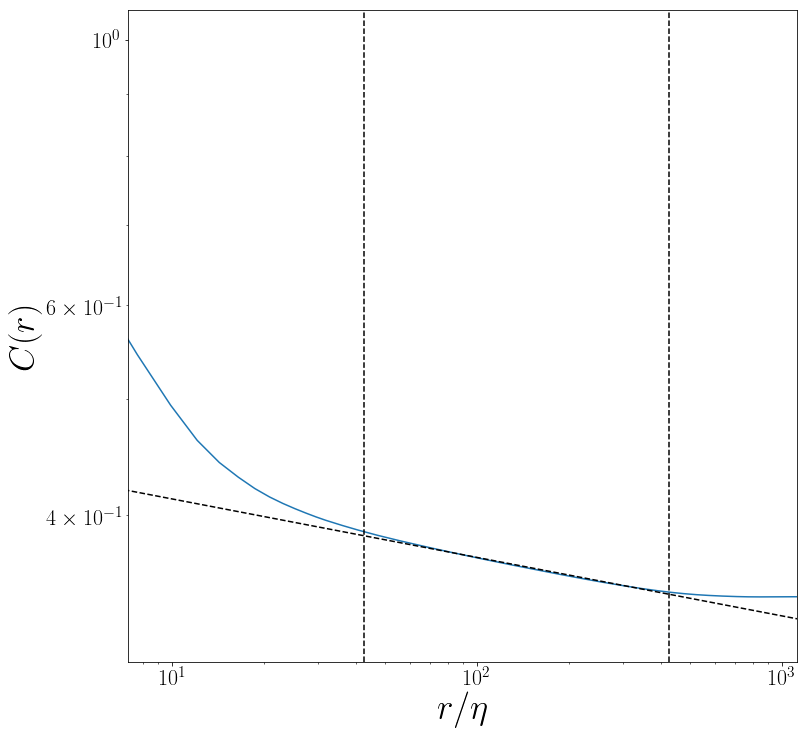

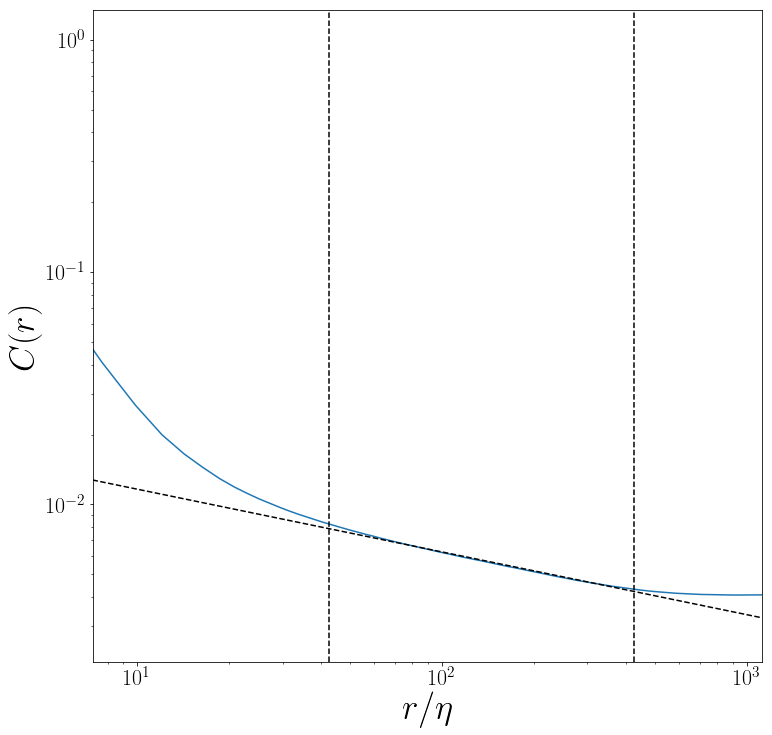

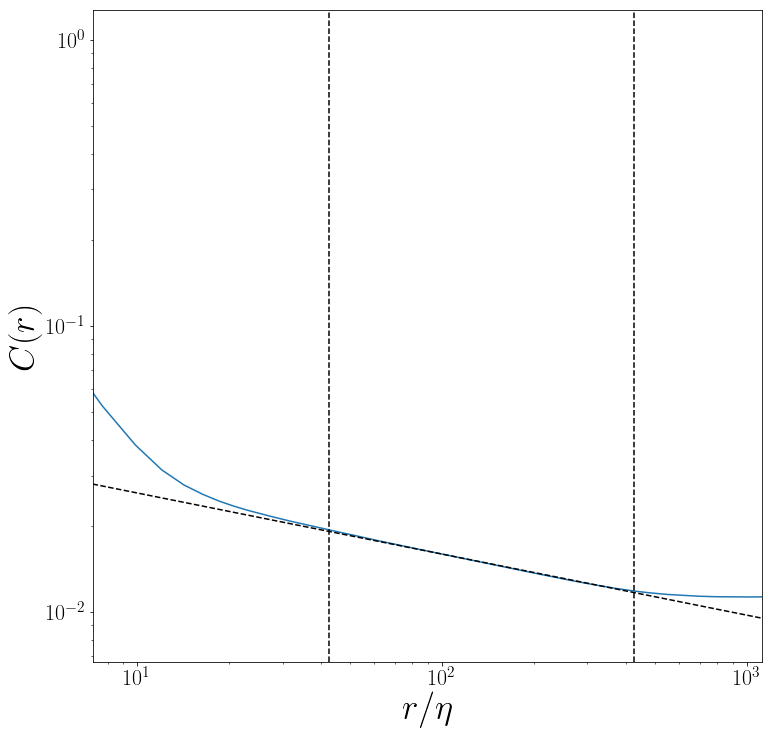

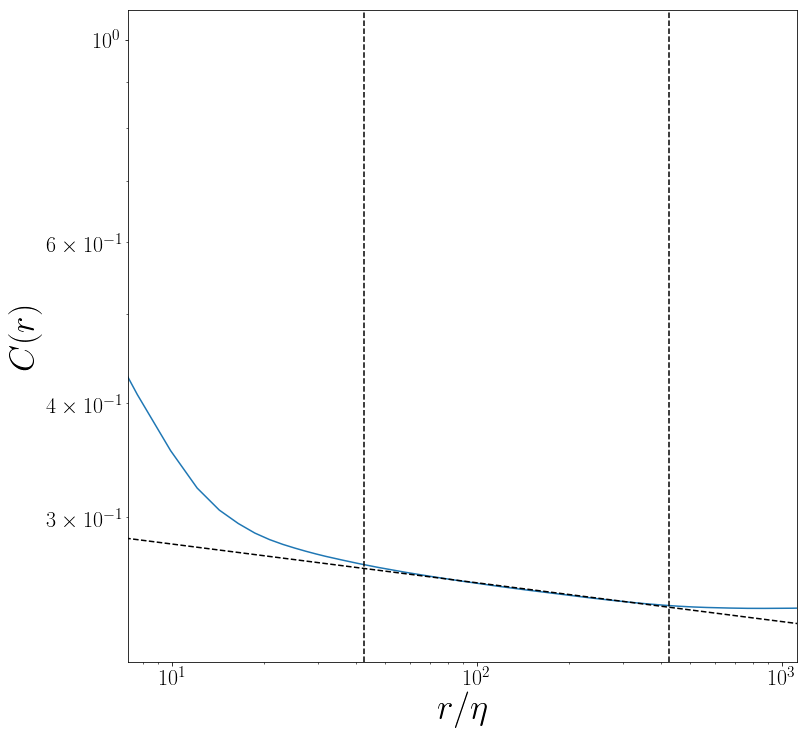

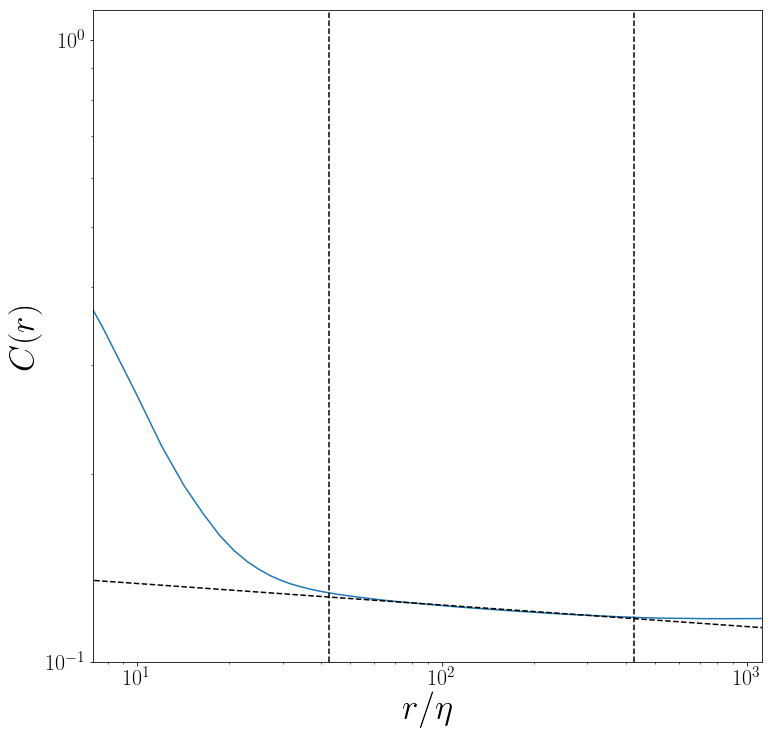

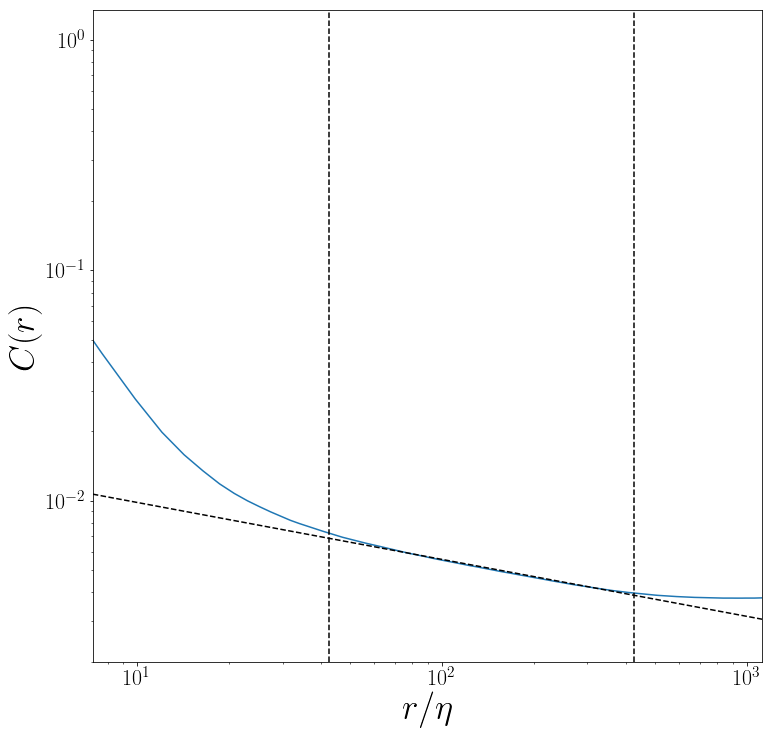

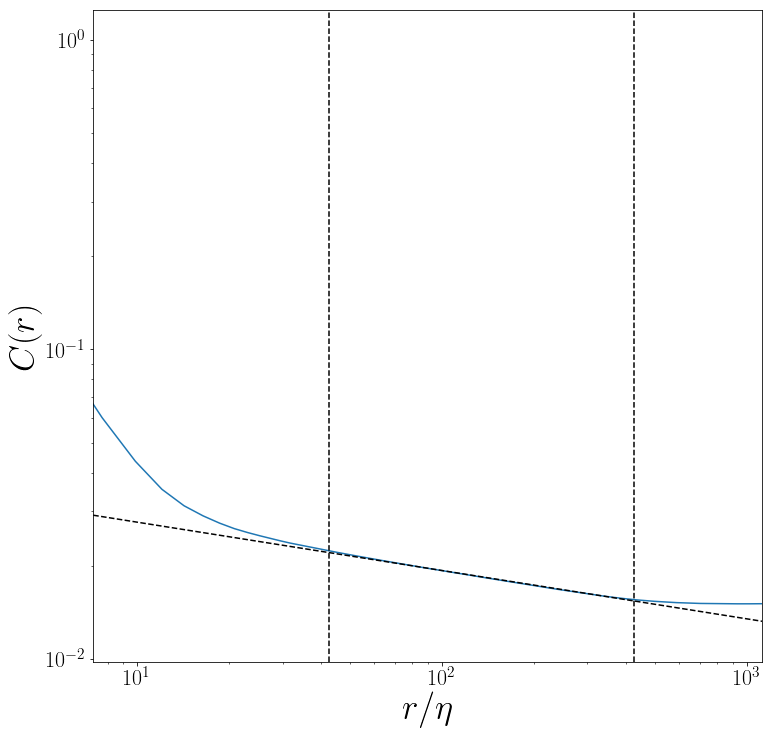

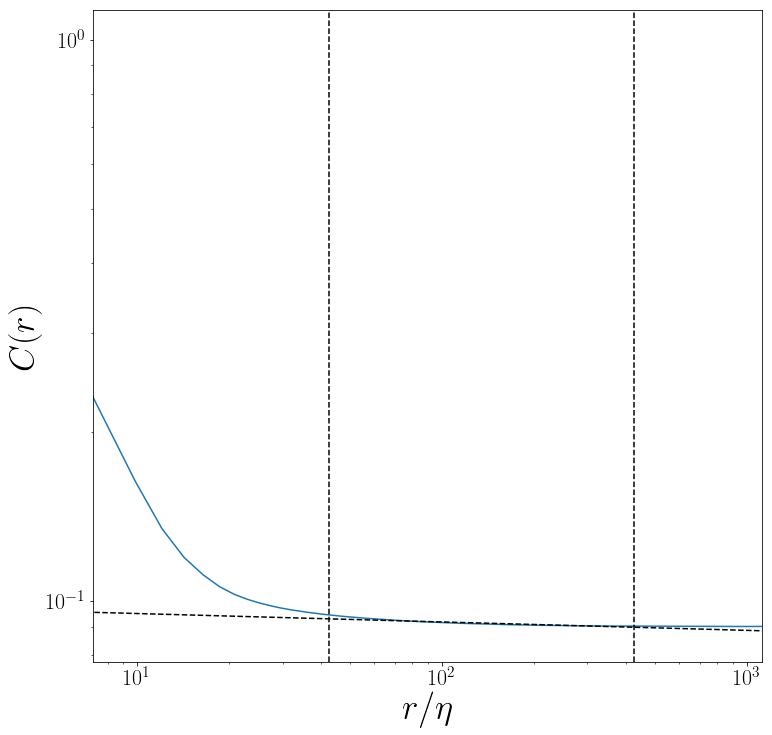

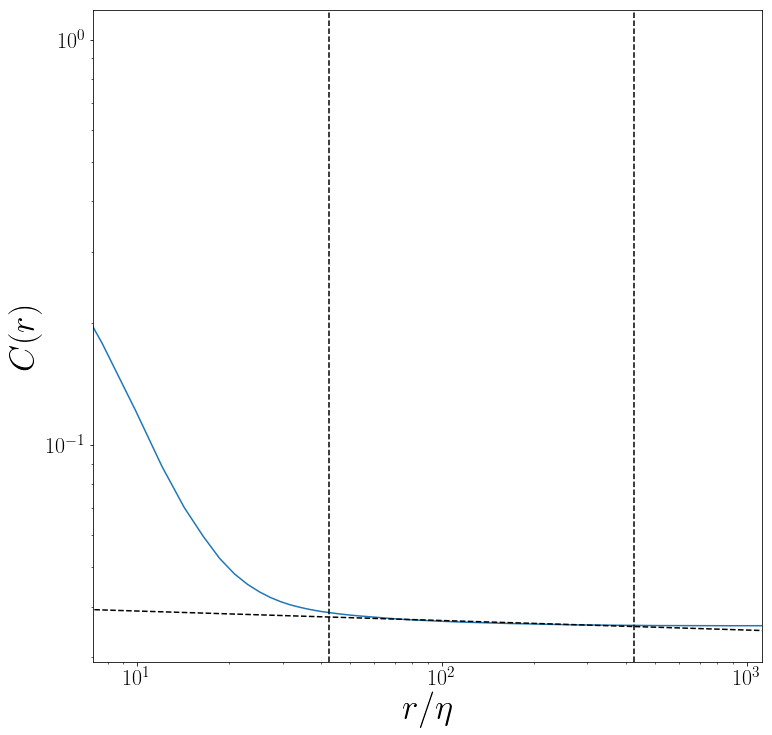

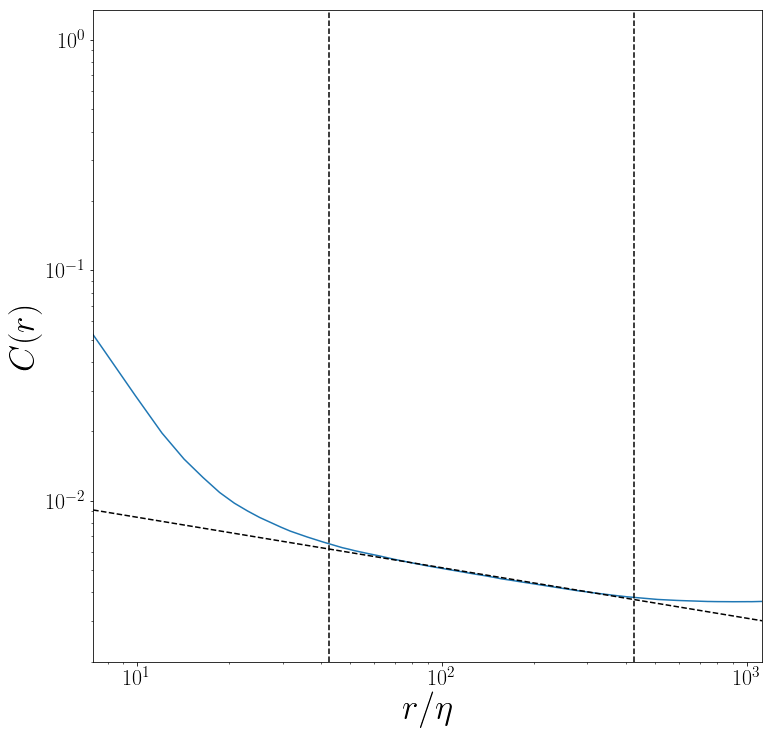

In [92]:
%%px

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('text', usetex=True)

if rank==0:
    eta = 0.00280
    
    rbins = np.linspace(minrt,maxrt,1+ner)    
    bins = (rbins[0:ner]+rbins[1:ner+1])/2
    tempRp = bins[(bins/eta>42.5)&(bins/eta<425)]/eta
    
    fiits = []    
    for i in range(E_bins-1):
        for j in range(E_bins-1):
            tQm = tl[i]; tQM = tl[i+1];            
            tRm = tl[j]; tRM = tl[j+1];
            
            plt.figure(figsize=(12,12))
            plt.xlabel(r'$r/\eta$', fontsize=35)
            plt.ylabel(r'$C(r)$', fontsize=35)
            plt.xlim([20*10**(-3)/eta,np.pi/eta])
            #plt.ylim([10**(-4),10**(0)])
            
            if(volFr[i*(E_bins-1)+j]>threshold):
                tcorr = lcorr[i*(E_bins-1)+j][llogr[i*(E_bins-1)+j]>0]
                tlogr = llogr[i*(E_bins-1)+j][llogr[i*(E_bins-1)+j]>0]
                tbins = bins[llogr[i*(E_bins-1)+j]>0]
                
                corrF = tcorr/tlogr
                tempCorrF = corrF[(tbins/eta>42.5)&(tbins/eta<425)]
                idx = (tempCorrF>0)
                
                if(len(tempCorrF[idx])>0):
                    fit = np.polyfit(np.log(tempRp[idx]),np.log(tempCorrF[idx]/corrF[0]),1)
                else:
                    fit = np.array([-4,0])
                    
                plt.loglog(bins/eta,corrF/corrF[0])
                plt.loglog(bins/eta,np.exp(fit[1])*((bins/eta)**(fit[0])),'k--')
            else:
                fit = np.array([-4,0])
                
            plt.axvline(x=42.50, color='k', linestyle='--')
            plt.axvline(x=425.0, color='k', linestyle='--')
            fiits.append(fit[0])
            print('t = ({one:.7f},{two:.7f})*sigma_2: Linear fit [alpha A] = {tree:.3f}'.format(one=(tQm+tQM)/2,two=(tRm+tRM)/2,tree=fit[0]+3))
            
    fiits = np.array(fiits)